## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [14]:
features = []
remote_folder = 'Gel_Studies/08_14_18_gel_validation' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 10
sizes = ['100', '200', '500']
nonnum = ['Particle Size', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']

counter = 0
for size in sizes:
    for num in range(1, vids+1):
        try:
            filename = 'features_{}nm_XY{}.csv'.format(size, '%02d' % num)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name='ccurtis.data')
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            print('{} size: {}'.format(filename, fstats.shape))
            fstats['Particle Size'] = pd.Series(fstats.shape[0]*[size], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        except:
            print('skip filename {}'.format(filename))

skip filename features_100nm_XY01.csv
features_100nm_XY02.csv size: (18207, 67)
features_100nm_XY03.csv size: (18178, 67)
features_100nm_XY04.csv size: (20452, 67)
features_100nm_XY05.csv size: (19292, 67)
skip filename features_100nm_XY06.csv
skip filename features_100nm_XY07.csv
skip filename features_100nm_XY08.csv
features_100nm_XY09.csv size: (21766, 67)
skip filename features_100nm_XY10.csv
features_200nm_XY01.csv size: (6072, 67)
features_200nm_XY02.csv size: (6483, 67)
features_200nm_XY03.csv size: (6513, 67)
features_200nm_XY04.csv size: (6412, 67)
features_200nm_XY05.csv size: (5249, 67)
features_200nm_XY06.csv size: (5248, 67)
features_200nm_XY07.csv size: (4674, 67)
features_200nm_XY08.csv size: (5585, 67)
features_200nm_XY09.csv size: (5700, 67)
features_200nm_XY10.csv size: (5198, 67)
features_500nm_XY01.csv size: (5325, 67)
features_500nm_XY02.csv size: (4709, 67)
features_500nm_XY03.csv size: (4125, 67)
features_500nm_XY04.csv size: (1606, 67)
features_500nm_XY05.csv si

In [ ]:
fstats_tot.to_csv('features.csv')

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [15]:
#with equal sample sizes for each particle type
import random
counter = 0
for size in sizes:
    fstats_type = fstats_tot[fstats_tot['Particle Size']==size].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 50000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

(97895, 69)
(57134, 69)
(55041, 69)


In [16]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
fstats_num = fstats_sub.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [20]:
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=13)

Cumulative explained variance:
0 component: 0.28730800810030444
1 component: 0.4251151379334627
2 component: 0.5015135700944842
3 component: 0.5623616691509447
4 component: 0.610249578598711
5 component: 0.6441549124970927
6 component: 0.6762193314453817
7 component: 0.7051736808631688
8 component: 0.7308747069272854
9 component: 0.7537207602085672
10 component: 0.7748237872530603
11 component: 0.7942168751377766
12 component: 0.8116706457579306


In [22]:
pcadataset.components.to_csv('components.csv')

In [26]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Mean straightness,Mean elongation,trappedness,Std asymmetry2,Std asymmetry3,Mean kurtosis,D_fit,boundedness,Std MSD_ratio,Mean frames,kurtosis,Std boundedness,Std alpha
1,Mean efficiency,Mean asymmetry3,boundedness,Std asymmetry1,Std elongation,Std kurtosis,alpha,trappedness,Mean MSD_ratio,Std fractal_dim,D_fit,Std trappedness,Mean alpha
2,Mean Deff1,Mean asymmetry2,asymmetry1,Quality,Std asymmetry2,Std MSD_ratio,straightness,frames,Mean kurtosis,Std frames,MSD_ratio,Std alpha,Std kurtosis
3,Mean fractal_dim,Mean asymmetry1,asymmetry2,Mean Quality,Std asymmetry1,Mean MSD_ratio,efficiency,Std kurtosis,Std kurtosis,Std Quality,fractal_dim,SN_Ratio,Std MSD_ratio
4,Std Deff1,Mean AR,Mean Quality,Mean SN_Ratio,Std AR,frames,frames,Mean kurtosis,Std alpha,Std kurtosis,Deff1,Quality,SN_Ratio


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [27]:
kmostat = pca.kmo(pcadataset.scaled)

0.917654608057


In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [45]:
import numpy as np
ncomp = 13
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='100'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='200'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='500'].values[:, -ncomp:], axis=0)

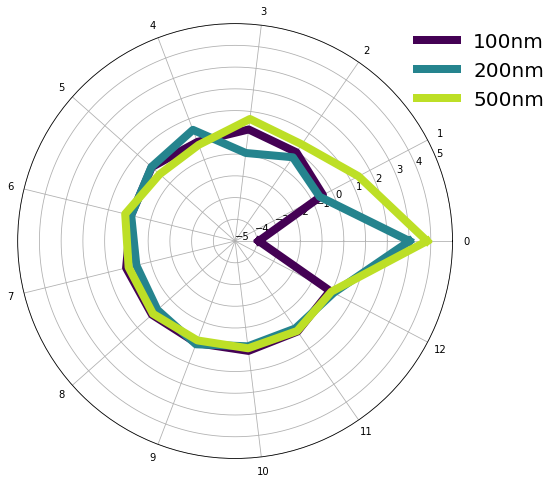

In [47]:
pca.plot_pca(dicti, savefig=True, labels=['100nm', '200nm', '500nm'], rticks=np.linspace(-5, 5, 11))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [ ]:
pcadataset.prcomps

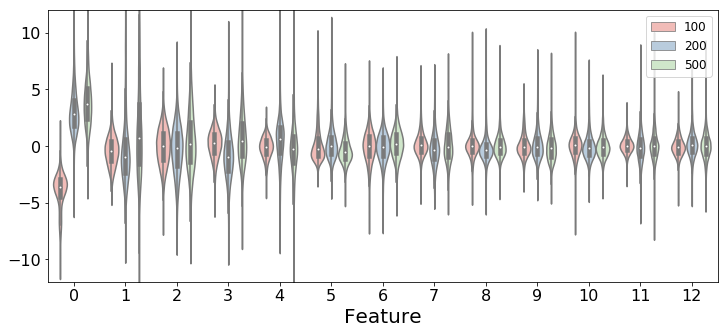

In [32]:
labels=['100', '200', '500']
feats = pca.feature_violin(pcadataset.final, label='Particle Size', lvals=labels, fsubset=13, yrange=[-12, 12])

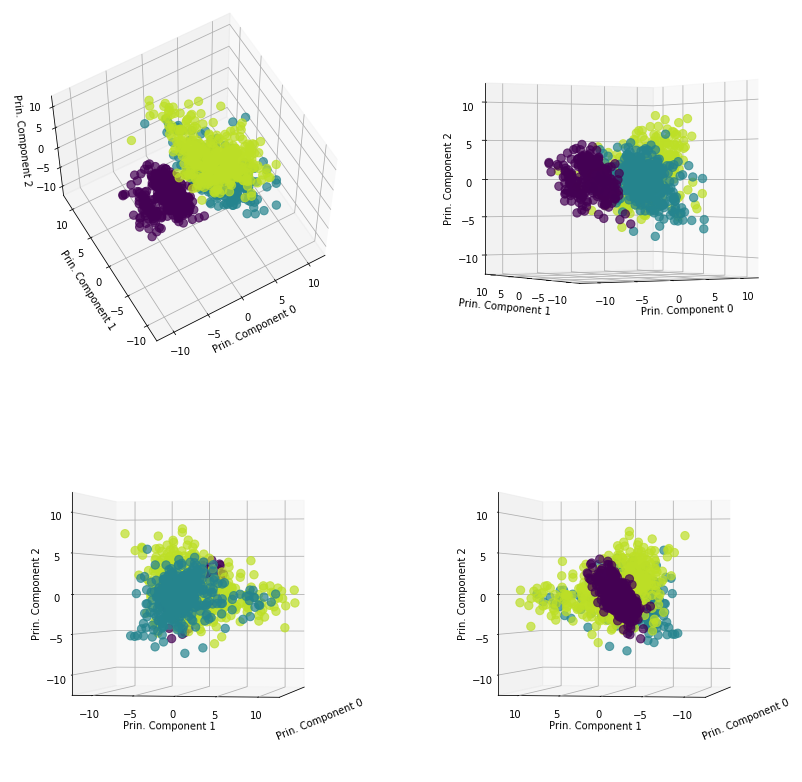

In [48]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Particle Size', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

In [49]:
ncomp = 14
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Particle Size', labels, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Particle Size'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.9551197219974294
Run 1: 0.9442709572999476
Run 2: 0.9471509496834388
Run 3: 0.9480316085114485
Run 4: 0.9578521445232542
Run 5: 0.9468272480601704
Run 6: 0.9459180273242253
Run 7: 0.9619983814918837
Run 8: 0.9564288094444708
Run 9: 0.9444137668396249
Run 10: 0.9598848003046604
Run 11: 0.9473794449469225
Run 12: 0.9232731946494026
Run 13: 0.9583519779121246
Run 14: 0.9492502499166945
Run 15: 0.9363783500737849
Run 16: 0.9482125005950397
Run 17: 0.9530870662160232
Run 18: 0.9518446232208312
Run 19: 0.950521254819822


In [50]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.9607999999999999 +/ 0.013359308032645671
0.94930975389156 +/ 0.008536812381026816


In [ ]:
fstats_num